# How a radar determines range
## Section 1: How a radar determines range  
A radar determines the range (distance) to an object by sending out a pulse of energy and then waits (listens) until the pulse is reflected off the object and returns to the radar.   Our signal model for the transmitted signal is:

$$x_{tx}(t) = \text{rect}\left(\frac{t}{T}\right)\cos(2\pi f t) $$  

The received signal will reflect off a scatterer at a distance $R$ away from the radar and be received at a time $t_{rx}$ later:

$$x_{rx}(t) = \text{rect}\left(\frac{t-t_{rx}}{T}\right)\cos(2\pi f (t - t_{rx})) $$  

Since the the signal is a wave propogating in free space we can determine the disctance to the point from the time it takes to come back to the receiver as:
$$R = \frac{ct_{rx}}{2}$$  
Where $c$ is the speed of light.  The reason for the division by two is because the time delay we measure is the time it takes for the wave to travel to the target, reflect off the scatterer, and come back to the radar.  Because of this the time delay we measure really corresponds to $2R$, hence the divide by two.  

The processing of the signal can determine the distance to an object by using a detector to detect when the signal returned in the receive window

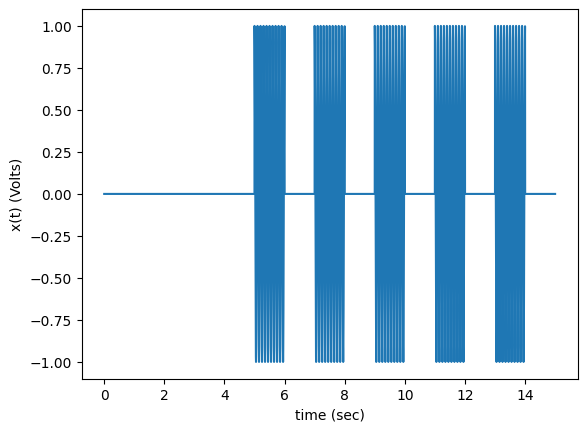

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light


# Parameters
fs = 1e3
tmax = 15
tt = np.arange(0, tmax, 1/fs)
f0 = 10
T = 1
t = np.arange(0, T, 1/fs)
pls = np.cos(2*np.pi*f0*t)


t0 = 5
dt = 2*T
SNR = 15
lgs = np.arange(t0, tmax, dt)

sig = np.zeros(tt.size)
for l in lgs:
    start = int(fs * l)
    stop = start + int(T * fs)
    sig[start:stop] = np.cos(2*pi*f0*t)


# print(pls.size, T * fs)
d = tt * speed_of_light / 2
plt.figure()
plt.plot(tt, sig)
plt.xlabel('time (sec)')
plt.ylabel('x(t) (Volts)')
plt.show()


Here we can see that the returned signal is quite weak.  One term we neglected is noise.  Our system will be noisy, so we can rewrite our received signal model as:
$$x_{rx}(t) = \text{rect}\left(\frac{t-t_{rx}}{T}\right)\cos(2\pi f (t - t_{rx})) + n(t) $$  
Where $n(t)$ is our system noise.  This is typically modelled as additive white guassian noise which means $n(t) \approx \mathcal{N}(0, \sigma_n)$ where $\sigma_n$ is the avg noise variance of our system.  

Let's see what the received signal looks like in the presence of noise: 

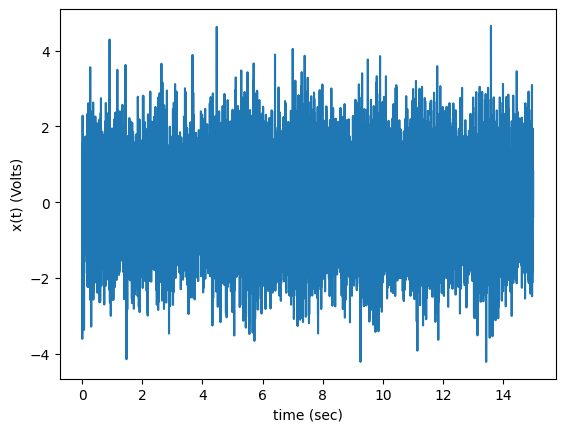

In [16]:
noise = np.random.normal(0, 1, len(tt))
z = sig + noise
plt.figure()
plt.plot(tt, z)
plt.xlabel('time (sec)')
plt.ylabel('x(t) (Volts)')
plt.show()

**TODO: Talk about max unambiguous range**
## Matched filtering  
The solution to determining the location of our signal in the presence of noise is to use matched filtering.  Matched filtering is an optimal filter in the presence of gaussian noise.  The matched filter is defined as the conjugate time reversed version of our original signal i.e)
$$h(t) = x^*(-t)$$  

To find the output of the matched filter process we convolve the matched filter with our input signal:

$$y(t) = h(t) * x(t)$$
$$y(t) = \int_{0}^{\infty}h(\tau)x(t-\tau)d\tau$$  
$$y(t) = \int_{0}^{\infty}x^*(\tau)x(t-\tau)d\tau$$  

There are a few ways to think about matched filtering:
1. Cross correlating your received signal with the signal you transmitted
    - Correlation is just an inner product!
2. Template matching 

For the example above lets see what the ouput looks like after matched filtering.  For simplicity we will rewrite the transmitted signal in terms of complex exponentials:

$$x_{tx}(t) = \text{rect}\left(\frac{t}{T}\right)e^{2j\pi f t}$$  
$$x_{rx}(t) = \text{rect}\left(\frac{t-t_{rx}}{T}\right)e^{2j\pi f (t - t_{rx})} $$   

It can be shown that convolving two rect functions together produces the triangle function $\Lambda(t)$  which is defined as:  

**TODO: INSERT DEFINITION**

So our received signal after matched filtering is given by:
$$y(t) = \Lambda\left(\frac{t-t_{rx}}{T}\right)e^{2j\pi f(t-t_{rx})} $$


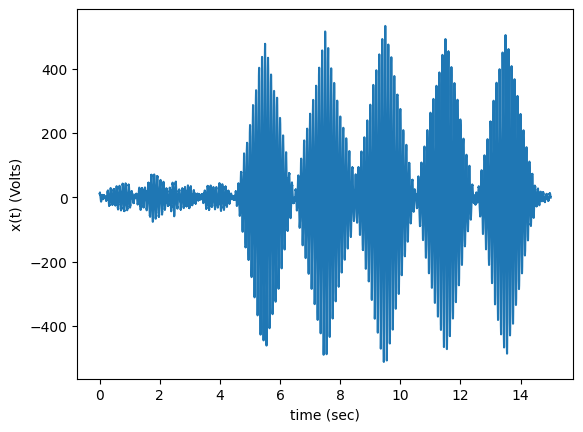

In [22]:
from scipy.signal import correlate
matched_filter_output = correlate(z, pls, 'same')

plt.figure()
plt.plot(tt, matched_filter_output)
plt.xlabel('time (sec)')
plt.ylabel('x(t) (Volts)')
plt.show()

## The problem with using sine waves

We can see now that our signal is impossible to detect and we cant determine the distance to objects anymore!  We can see that there are two fundamental problems with determining range using sine waves:
1. Difficult to distinguish in the presence of noise
2. Resolution of a pulsed sine wave is $\rho = \frac{1}{2}cT$.
    - If we want fine resolution we need short pulse durations
    - The shorter our pulse duration the less feasible it is for the system to transmit the same amount of power
        - Shorter pulse duration -> lower SNR  

What we would like to find is a method which will allow us to maintain SNR while keeping the pulse duration short.

## Linear frequency modulation
Rather than using a short rectangular pulse with a duration $T_{rect} = \frac{1}{B}$, we instead spread the signal’s frequency content over a longer duration $T$. One way of achieving this is *linear frequency modulation* (LFM), where the frequency of the pulse increases or decreases linearly over time. This is also know as a chirp waveform.

Mathematically, the real portion a chirped signal can be represented as:
$$s(t) = A e^{j\left(2\pi f_0 t + \pi \gamma t^2 \right)}$$
where:  
* $f_0$ is the initial frequency,
* $B$ is the bandwidth
* $\gamma = \frac{B}{T}$ is the chirp rate

This process has left us with a longer duration pulse that retains the bandwidth of the short rect. One helpful way of thinking of this process is that we have applied a linearly increasing phase delay to each frequency component of the short duration pulse we wanted. In order to recover a short duration pulse from our chirp signal, all we need to do is apply the opposite delay to the signal. This can be done via matched filtering.  

The waveform is called a linear frequency modulation because the frequecny increases linearly as time increases.  We can see this by remembering that frequency is defined as the time derivative of phase:
$$f(t) = \frac{d\phi}{dt}$$
$$f(t) = \frac{d\phi}{dt}(2\pi f_0 t + \pi \gamma t^2 )$$
$$f(t) = 2\pi f_0 + 2\pi \gamma t $$  

Let's examine what this waveform looks like graphically.  We can see what the signal looks like over time:

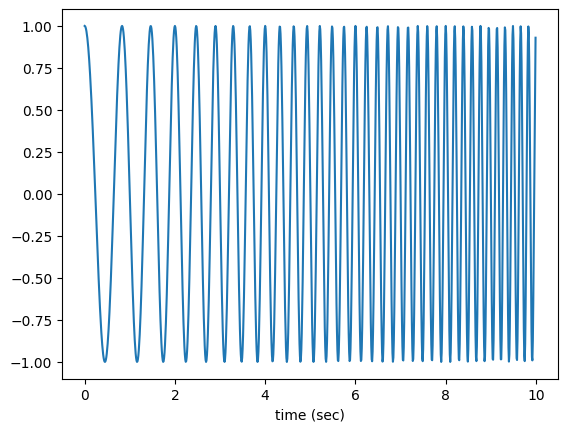

In [23]:
from scipy.signal import chirp, ShortTimeFFT
from scipy.signal.windows import gaussian
T = 0.01
N = 1000
t = T * np.arange(N)

sig = chirp(t, f0=1, f1=6, t1=10, method='linear', complex=True)
plt.figure()
plt.plot(t, np.real(sig))
plt.xlabel('time (sec)')
plt.show()

We can also look at how the frequency of a chirp changes with frequency over time by looking at its spectrogram 

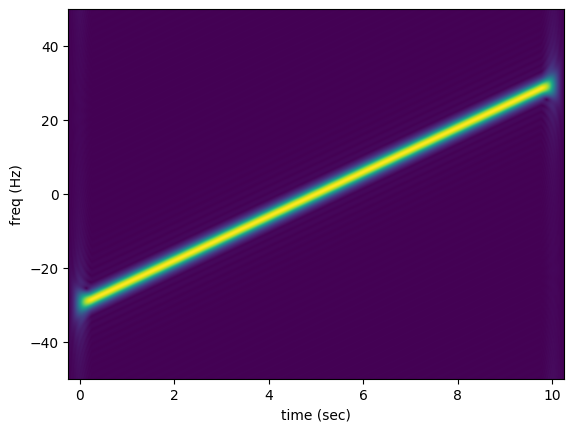

In [24]:

win = gaussian(50, std=12, sym=True)
SFT = ShortTimeFFT(win, hop=2, fs=1/T, mfft=800, scale_to='magnitude')
z_lin = chirp(t, f0=-30, f1=30, t1=N*T, method="linear", complex=True)
SFT.fft_mode = 'centered'  # needed to work with complex signals
plt.figure()
plt.imshow(np.abs(SFT.stft(z_lin)), origin='lower', extent=SFT.extent(N), aspect='auto')
plt.xlabel('time (sec)')
plt.ylabel('freq (Hz)')
plt.show()

We can also see this by looking at its fourier transform

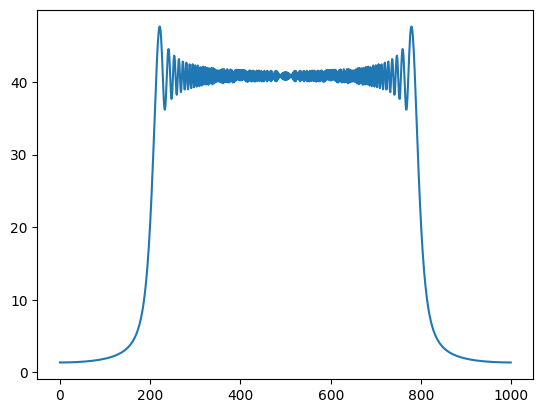

In [25]:
z_lin_fft = np.fft.fftshift(np.fft.fft(z_lin))
plt.figure()
plt.plot(np.abs(z_lin_fft))
plt.show()

What we are seeing here is known as the gibbs phenomena 

## Matched filter output of a chirp signal
For this derivation instead of using convolution in time we will take the fourier transform of the matched filter and input signal which means:
$$Y(\omega) = H(\omega)X(\omega)$$

Recall the following properties of the fourier transform:
1. $\mathcal{F}\{x^*(t)\} \rightarrow X^*(-\omega)$
2. $\mathcal{F}\{x(-t)\} \rightarrow X(-\omega)$  

The fourier transform of the matched filter is given by:
$$H(\omega) = \mathcal{F}\{x^*(-t)\} = X^*(\omega)$$  

We can rewrite this in terms of gain and phase as:
$$H(\omega) = |X(\omega)|e^{-j\angle X(\omega)}$$  

Now what we receive is a time delayed version of the transmit signal, so $X(\omega)$ becomes:
$$\mathcal{F}\{x(t-\tau)\} = X(\omega)e^{-j2\pi f \tau}$$  

This means the matched filtered result of a singal received at time $\tau$ later and our matched filter is:
$$Y(\omega) = X(\omega) X^*(\omega)$$

$$Y(\omega) = (|X(\omega)|e^{-j\angle X(\omega)})(|X(\omega)|e^{j\angle X(\omega)}e^{j2\pi f \tau}) $$
$$Y(\omega) = |X(\omega)|^{2}e^{j2\pi f \tau} $$

For a finite bandwidth signal (chirp) with bandwidth $B$ its spectrum $|X(\omega)|$ will be approimately a rect function. i.e)
$$|X(\omega) = \text{rect}\left(\frac{\omega}{B}\right)$$  

Plugging this in we get:
$$Y(\omega) = |\text{rect}\left(\frac{\omega}{B}\right)|^{2}e^{j2\pi f \tau} $$
$$Y(\omega) = \text{rect}\left(\frac{\omega}{B}\right)e^{j2\pi f \tau} $$  

To find the response in the time domain we take the inverse transform.  Recall that
$$\mathcal{F}^{-1}\{\text{rect}\left(\frac{\omega}{B}\right) \} = B\text{sinc}(Bt)$$  
and also recall the time shifting property of the fourier transform
$$\mathcal{F}^{-1}\{ X(\omega)e^{-j2\pi f \tau}\} = x(t-\tau)$$  

Using these two propierties we find that the matched filter output for receiving a band limited chirp a time $\tau$ later is:
$$y(t) = B\text{sinc}(B(t-\tau))$$  

When the transmit signal hits a target and returns as an echo, it still has a long duration. To retrieve a short-duration, high-energy pulse, we process the signal with a **matched filter** in the receiver.

PUT IN EQUATION OF A MATCHED FILTER, DERIVE SINC

Once way to think about what happened here is that we applied the opposite phase delay to the signal as when ewe created the chirp. This realigns the frequency components of the signal causing all of the frequencies to constructively interfere at the pulse center time, thus recovering a high-energy short-duration pulse. For a chirped pulse of unit amplitude, after matched filtering:
* The compressed pulse durration is $\tau_c \approx \frac{1}{B}$
* The compressed pulse is amplified by $\sqrt{TB}$


## Pulse compression ration
In general pulse compression ratio is the change in peak power of the signal after matched filtering.  If a signal prior to matched filtering has peak power $P_0$ and post matched filtering has peak power $P_m$ then pulse compression ratio is defined as:
$$PCR = \frac{P_m}{P_0}$$ 

For a chirp waveform the pulse compression ratio is defined as the time bandwidth product:
$$PCR = T_p B$$  
Where $T_p$ is the pulse duration and $B$ is the bandwidth of the signal

In [ ]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

def lfm_chirp(
    t: npt.NDArray, 
    t0: float, 
    f0: float, 
    k: float, 
    T: float,
) -> npt.NDArray:
    """
    Generate an LFM chirp signal.

    Parameters
    ----------
    t: `[N,] float`
        Time samples

    t0: `float`
        Start time of the chirp

    f0: `float > 0`
        Start frequency of the chirp (Hz)

    k: `float`
        Chirp rate (Hz/s)

    T: `float > 0`
        Pulse duration (seconds)

    Returns
    -------
    chirp_signal: `[N,] float`
        LFM chirp signal
    """
    # Initialize the chirp signal with zeros
    t0 -= T/2
    chirp_signal = np.zeros_like(t, dtype=float)
    
    # Determine the times within the chirp duration
    mask = (t >= t0) & (t <= t0 + T)
    t_within = t[mask] - t0  # Time relative to the chirp start
    
    # Compute the instantaneous phase for the chirp
    phase = 2 * np.pi * (f0 * t_within + 0.5 * k * t_within**2)
    
    # Set the chirp signal for the valid times
    chirp_signal[mask] = np.cos(phase)
    
    return chirp_signal


def generate_overlap():
    x = np.linspace(-10, 10, 1000)
    waveform1 = lfm_chirp(x, 0, 1, 2, 2)
    # waveform1 = np.exp(-x**2 / 4)  # Gaussian function
    # returned1 = np.heaviside(x + 2, 1) - np.heaviside(x - 2, 1)  # Rectangular pulse
    returned1 = 0.5 * lfm_chirp(x, 0, 1, 2, 2)
    
    # Shift the second waveform
    offset = np.linspace(-500, 500, 1000)
    separation = np.arange(0, 8, 0.1)
    convolution = np.zeros((1000, len(separation)))
    for i, shift in enumerate(offset):
        for j, sep in enumerate(separation):
            returned1_shifted = np.roll(returned1, int(shift))
            waveform2 = lfm_chirp(x - sep, 0, 1, 2, 2)
            overlap = sum((waveform1 + waveform2) * returned1_shifted) / len(x)
            convolution[i, j] = overlap
    
    # Compute the overlap integral (convolution at this step)
    return convolution

convolution = generate_overlap()

def convolution_demo(slider=0, separation=0.1):
    """
    Interactive demonstration of convolution.
    offset: Amount to slide the second waveform relative to the first.
    """
    offset = slider - 500
    # Define the waveforms
    x = np.linspace(-10, 10, 1000)
    waveform1 = lfm_chirp(x, 0, 1, 2, 2)
    waveform2 = lfm_chirp(x - separation, 0, 1, 2, 2)
    # waveform1 = np.exp(-x**2 / 4)  # Gaussian function
    # waveform2 = np.heaviside(x + 2, 1) - np.heaviside(x - 2, 1)  # Rectangular pulse
    returned1 = 0.5 * lfm_chirp(x, 0, 1, 2, 2)
    
    # Shift the second waveform
    returned1_shifted = np.roll(returned1, offset)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Waveforms
    plt.subplot(2, 1, 1)
    plt.plot(x, waveform1 + waveform2, label="Return Signal")
    plt.plot(x, returned1_shifted, label="Template")
    plt.title("Return Signal and Template")
    plt.xlabel("x")
    plt.ylabel("Amplitude")
    plt.ylim((-2, 2))
    plt.legend()
    plt.grid()
    
    # Subplot 2: Convolution value
    plt.subplot(2, 1, 2)
    plt.plot(x[0:slider], convolution[0:slider, int(separation * 10)])
    plt.title("Combined Output")
    plt.ylabel("Amplitude")
    plt.xlim((-10, 10))
    plt.ylim((-0.05, 0.05))
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plt.close('all')

# Interactive slider for waveform offset
interact(
    convolution_demo,
    slider=IntSlider(value=0, min=50, max=950, step=1, description="Offset"),
    separation=FloatSlider(value=1, min=0, max=7.9, step=0.1, description="Separation"),
)


Now lets explore what the matched filtered output would look like from our first example if we were to use chirp instead of sine waves

/mnt/c/Users/Austin/Documents/GitHub/radar_learning/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/c/Users/Austin/Documents/GitHub/radar_learning/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


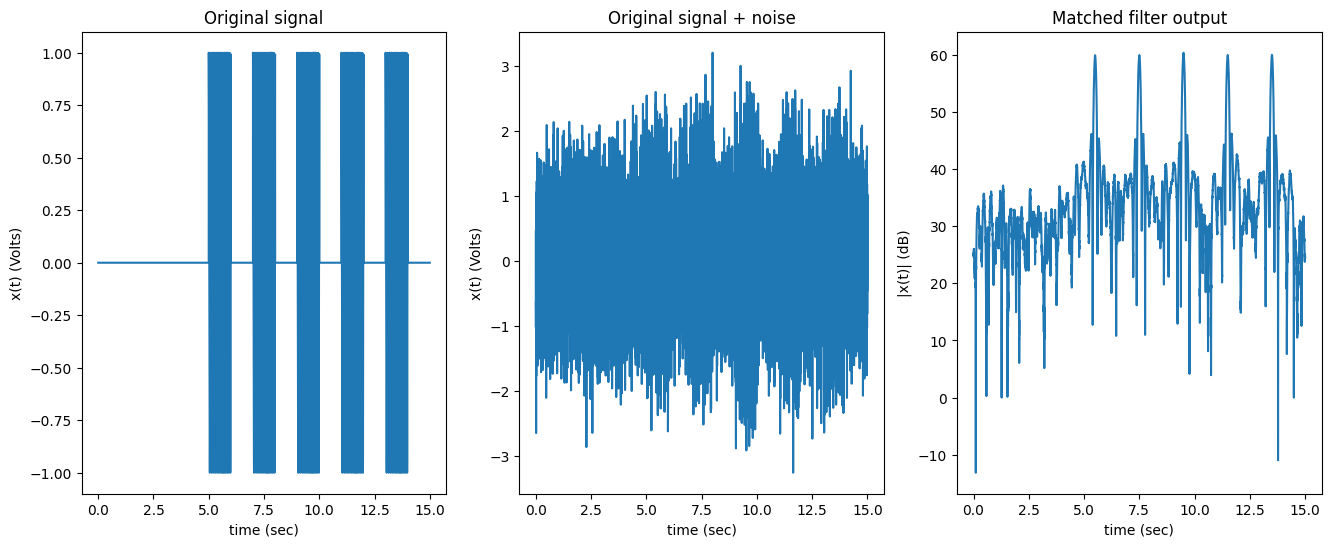

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
from scipy.signal import correlate

# Parameters
fs = 1e3
tmax = 15
tt = np.arange(0, tmax, 1/fs)
f0 = 10
T = 1
t = np.arange(0, T, 1/fs)
bandwidth = 10
pls = chirp(t, f0=f0, f1=f0+bandwidth, t1=T, method='linear', complex=True)


t0 = 5
dt = 2*T
SNR = 15
lgs = np.arange(t0, tmax, dt)

sig = np.zeros(tt.size, dtype=np.complex128)
for l in lgs:
    start = int(fs * l)
    stop = start + int(T * fs)
    sig[start:stop] = chirp(t, f0=f0, f1=f0+bandwidth, t1=T, method='linear', complex=True)


noise = 1 / np.sqrt(2) * (np.random.normal(0, 1, len(tt)) + 1j * np.random.normal(0, 1, len(tt)))
z = sig + noise
matched_filter_output = correlate(z, pls, 'same')

# print(pls.size, T * fs)
fig, axs = plt.subplots(ncols=3, figsize=(16, 6))
axs = axs.flatten()


axs[0].plot(tt, sig)
axs[0].set_xlabel('time (sec)')
axs[0].set_ylabel('x(t) (Volts)')
axs[0].set_title('Original signal')

axs[1].plot(tt, z)
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('x(t) (Volts)')
axs[1].set_title('Original signal + noise')

axs[2].plot(tt, 20*np.log10(np.abs(matched_filter_output)))
axs[2].set_xlabel('time (sec)')
axs[2].set_ylabel('|x(t)| (dB)')
axs[2].set_title('Matched filter output')
plt.show()

Now we have a way to determine the distance to the returns with fine resolution in the presence of noise!

## Section 4: Stretch processing
The linear FM waveform is popular in radar systems because its large time-bandwidth product can provide good range resolution. However, the large bandwidth of this waveform makes digital matched filtering difficult because it requires expensive, high-quality analog-to-digital converters. Stretch processing, also known as deramping or dechirping, is an alternative to matched filtering. Stretch processing provides pulse compression by looking for the return within a predefined range interval of interest. Stretch processing occurs in the analog domain. Unlike matched filtering, stretch processing reduces the bandwidth requirement of subsequent processing.  This means that we matched filter in hardware instead of digitally.  

This mode of operations makes use of the fact that a time offset (range) is essentially corresponds to a frequency offset.  An example block diagram can be seen below:  

![stretch_block_diagram](./images/stretch.drawio.png)  

Here we note that there is a branching path after the amplifier sending a copy of the waveform down to mixer on receive.  This is the analog matched filtering.  A view of what the waveform looks like after matched filtering can be seen below:

![stretch_processing](./images/stretch_processing.ppm)  

The process of mixing with the refernce waveform instead of digitally downconverting the signal can also be thought as encoding your range information as a beat frequecny where the beat frequency is the difference in frequency between two chirps:

![stretch_processing](./images/beat.PNG)  


Mathematically we can define stretch processing using the definition of the transmit and receive waveforms as:
$$x_{tx}(t) = e^{j\left(2\pi f_0 t + \pi \gamma t^2 \right)}$$
$$x_{rx}(t) = e^{j\left(2\pi f_0 (t-\tau_{rx}) + \pi \gamma (t-\tau_{rx})^2 \right)}$$   

For the mixing operation in hardware (analogous to multiplication) we'll define the reference waveform we mix as 
$$h(t) = e^{-j\left(2\pi f_0 t + \pi \gamma t^2 \right)} $$
The output of the mixer is:
$$y(t) = x_{rx}(t) \cdot h(t)$$
$$y(t) = e^{j\left(2\pi f_0 (t-\tau_{rx}) + \pi \gamma (t-\tau_{rx})^2 \right)} \cdot e^{-j\left(2\pi f_0 t + \pi \gamma t^2 \right)}$$  
$$y(t) = e^{j\left(2\pi f_0t - 2\pi f_0\tau_{rx} + \pi \gamma t^2 - 2\pi \gamma t\tau_{rx} + \pi \gamma \tau_{rx}^2 \right)} \cdot e^{-j\left(2\pi f_0 t + \pi \gamma t^2 \right)}$$  
$$y(t) = e^{j\left( - 2\pi f_0\tau_{rx} - 2\pi \gamma t\tau_{rx} + \pi \gamma \tau_{rx}^2 \right)}$$  
Each component can be classified as follows:

| term    | meaning | notes |
| -------- | ------- | ------- | 
| $- 2\pi \gamma t\tau_{rx}$  | Range term    | We use this to determine distacne to target |
| $- 2\pi f_0\tau_{rx}$ | Doppler term     | We use this to estimate the speed of a target over multiple pulses |
| $\pi \gamma \tau_{rx}^2$    | Residual video phase (RVP)  | This is sometimes referred to as a skew term.  Removal of this term is referred to as "deskewing"|

the range term is the only thing varying through time since all other terms are constant with time and only dependent on the time delay to the target.   

To figure out the distance to the target we'll compare the range term to a sinusoid with beat frequency $f_b$

$$e^{j2\pi f_b t} = e^{j2\pi \gamma t\tau_{rx} }$$  
From here we see that
$$ f_b = \gamma \tau_{rx}$$ 
or equivalently  

$$\tau_{rx} = \frac{f_b}{\gamma}$$  
We know that $\tau_{rx} = \frac{2R}{c}$ and $\gamma = \frac{B}{T}$  So pluggging those in we get:
$$\frac{2R}{c} = \frac{f_b}{\frac{B}{T}} $$  
$$\frac{2R}{c} = \frac{f_bT}{B} $$  
Now solving for $R$ yields:
$$R = \frac{cf_bT}{2B}$$  

This has an interesting result because our max range is limited by our A/D sampling rate as opposed to how long we listen for a waveform.   

To determine range for stretch processing, all one needs to do is perform a range FFT on the receive window and spikes will occur at target locations at their corresponding beat frequencies 

## Section 5: Stepped frequency waveforms
Stepped frequency waveforms are a method for achieving fine range resolution with low sampling rate which avoiding analog mixing.  This is often referred to as step chirp.  

Step chirp is the process of transmitting multiple chirps with lower bandwidth but changing center frequency on each chirp.  Downstream processing will combine each small bandwidth chirp into a single chirp with large bandwidth.  The process of combining multiple steps together is known as step combination.  Mathematically the return for a single pulse described as:

$$x(t) = \sum_{m=0}^{M-1}x_p(t-mT)e^{j2\pi m \Delta F (t-mT)}$$  

Let's example a simple where we have two steps (`M=2`)

$$x(t) = e^{j\left(2\pi f_0 t + \pi \gamma t^2 \right)}\cdot e^{j2\pi 0 \Delta F t} + e^{j\left(2\pi f_0 (t-T) + \pi \gamma (t-T)^2 \right)}\cdot e^{j2\pi 1 \Delta F ((t-T))}$$

$$x(t) = e^{j\left(2\pi f_0 t + \pi \gamma t^2 \right)} + e^{j\left(2\pi (f_0 +\Delta F) (t-T) + \pi \gamma (t-T)^2 \right)}$$  

We can continue this process for any number of steps `M` but we see that all that changes per step is the center frequecny per pulse and the pulse transmission time.  In this example we use two pulses to get the bandwidth of a chirp that has twice the original bandwidth of our initial chirp

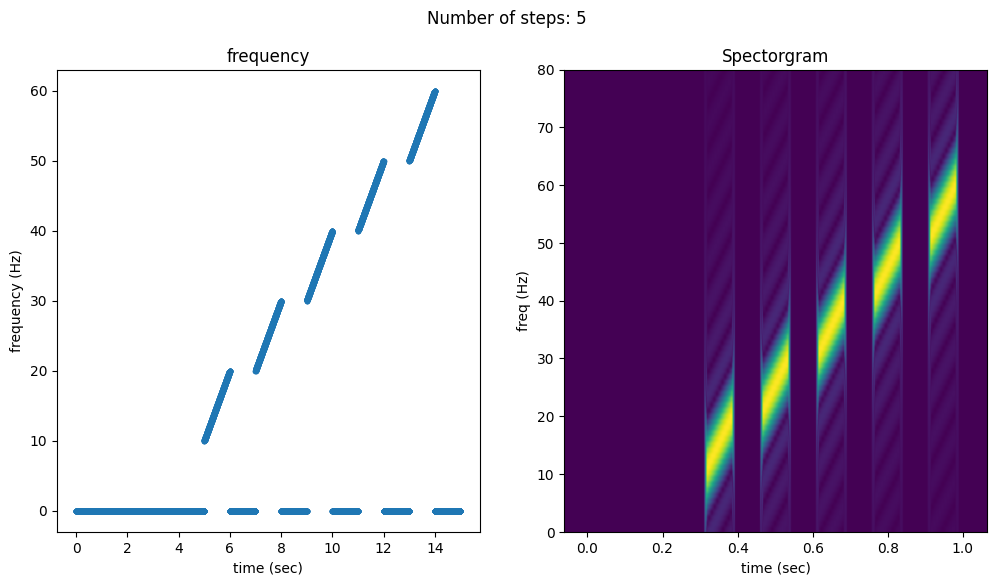

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1e3
tmax = 15
tt = np.arange(0, tmax, 1/fs)
f0 = 10
T = 1
t = np.arange(0, T, 1/fs)
delta_f = 10

t0 = 5
dt = 2*T
SNR = 15
lgs = np.arange(t0, tmax, dt)

sig = np.zeros(tt.size, dtype=np.complex128)
freqs = np.zeros(tt.size)
for ii, l in enumerate(lgs):
    start = int(fs * l)
    stop = start + int(T * fs)
    freqs[start:stop] = np.linspace(f0 *(ii+1), f0 *(ii+1) + delta_f, t.size)
    sig[start:stop] = chirp(t, f0=f0*(ii+1), f1=f0*(ii+1) + delta_f, t1=T, method='linear', complex=True)


fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
axs = axs.flatten()
axs[0].plot(tt, freqs, '.')
axs[0].set_xlabel('time (sec)')
axs[0].set_ylabel('frequency (Hz)')
axs[0].set_title('frequency')

win = gaussian(128, std=50, sym=True)
SFT = ShortTimeFFT(win, hop=2, fs=fs, mfft=1024, scale_to='magnitude')
SFT.fft_mode = 'centered'  # needed to work with complex signals
axs[1].imshow(np.abs(SFT.stft(sig)), origin='lower', extent=SFT.extent(N), aspect='auto')
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('freq (Hz)')
axs[1].set_ylim([0, 80])
axs[1].set_title('Spectorgram')
fig.suptitle(f'Number of steps: {lgs.size}')
plt.show()

In terms of matched filtering the method is the same but you need to make sure the correct matched filter is applied to the correct step